Here will investigate whether if in practice we can non-vacuously compress fully connected neural networks according to the framework. Throughout we will investigate the various properties of layer matrices are detailed in the report, and we will also implement the algorithms detailed in the report.

In [1]:
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

import numpy as np
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt

import math

In [2]:
input_size = 784
num_classes = 10
num_epochs = 20
batch_size = 100
learning_rate = 0.1

In [3]:
# MNIST dataset 
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())

reduced_train_index=list(range(10000))
reduced_test_index=list(range(2000))

subset_train_dataset=Subset(train_dataset, reduced_train_index)
subset_test_dataset=Subset(test_dataset, reduced_test_index)

# Data loader
train_loader = DataLoader(dataset=subset_train_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(dataset=subset_test_dataset, batch_size=batch_size, shuffle=False) 

In [4]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.input_layer = nn.Linear(input_size, hidden_size)
        self.fc1 = nn.Linear(hidden_size,hidden_size) 
        self.fc2 = nn.Linear(hidden_size,hidden_size) 
        self.fc3 = nn.Linear(hidden_size,hidden_size) 
        self.fc4 = nn.Linear(hidden_size,hidden_size)
        self.output_layer = nn.Linear(hidden_size, num_classes)  
    
    def forward(self, x):
        x = self.input_layer(x)
        x = x.relu()
        x = self.fc1(x)
        x = x.relu()
        x = self.fc2(x)
        x = x.relu()
        x = self.fc3(x)
        x = x.relu()
        x = self.fc4(x)
        x = x.relu()
        x = self.output_layer(x)
        return x

In [5]:
def network_layer_weight_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'weight' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

def network_layer_bias_extraction(model):
    network_weights=[]
    for para in model.named_parameters():
        if 'bias' in para[0]:
            network_weights.append(para[1].detach().numpy())
    return network_weights

In [6]:
model = NeuralNet(input_size, 128, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6) / math.sqrt(param.shape[0] + param.shape[1])
            param.data.uniform_(-bound, bound)
    
xavier_init(model)

init_network_weights=network_layer_weight_extraction(model)
init_network_bias=network_layer_bias_extraction(model)

def train_epoch():
    for images, labels in train_loader:  
        images = images.reshape(-1, 28*28)
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()

def train_accuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in train_loader:
            images = images.reshape(-1, 28*28)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

for n in range(num_epochs):
    loss=train_epoch()
    acc=train_accuracy()
    print('Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}'.format(n+1,loss,acc))

Epoch 1, Loss: 0.889, Accuracy: 75.190
Epoch 2, Loss: 0.288, Accuracy: 90.590
Epoch 3, Loss: 0.338, Accuracy: 93.280
Epoch 4, Loss: 0.169, Accuracy: 93.960
Epoch 5, Loss: 0.242, Accuracy: 95.680
Epoch 6, Loss: 0.116, Accuracy: 96.540
Epoch 7, Loss: 0.173, Accuracy: 95.930
Epoch 8, Loss: 0.180, Accuracy: 96.050
Epoch 9, Loss: 0.068, Accuracy: 98.340
Epoch 10, Loss: 0.029, Accuracy: 98.490
Epoch 11, Loss: 0.066, Accuracy: 98.350
Epoch 12, Loss: 0.050, Accuracy: 99.070
Epoch 13, Loss: 0.029, Accuracy: 99.020
Epoch 14, Loss: 0.010, Accuracy: 99.440
Epoch 15, Loss: 0.003, Accuracy: 99.690
Epoch 16, Loss: 0.006, Accuracy: 99.770
Epoch 17, Loss: 0.010, Accuracy: 99.890
Epoch 18, Loss: 0.012, Accuracy: 99.880
Epoch 19, Loss: 0.006, Accuracy: 99.940
Epoch 20, Loss: 0.004, Accuracy: 99.970


In [7]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28)
        labels = labels
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: {} %'.format(100 * correct / total))

Accuracy of the network on the 10000 test images: 94.25 %


In [37]:
trained_network_weights=network_layer_weight_extraction(model)
trained_network_bias=network_layer_bias_extraction(model)

number_of_layers=len(trained_network_weights)
number_datapoints=len(train_dataset)

network_inputs=[]
for x in train_dataset:
    network_inputs.append(torch.reshape(x[0],(784,)))

In [38]:
def inputs_at_layers(network_input, network_weights, network_bias, no_layers):
    def relu(x):
        return(np.maximum(0,x))
    inputs_pre_activation=[network_input]
    inputs_post_activation=[network_input]
    for k in range(no_layers-1):
        inputs_pre_activation.append([dot(network_weights[k],x)+network_bias[k] for x in inputs_post_activation[-1]])
        inputs_post_activation.append([relu(vec) for vec in inputs_pre_activation[-1]])
    return inputs_pre_activation, inputs_post_activation

In [10]:
def model_layer_cushion(inputs, network_weights, no_layers, no_datapoints):
    layer_cushion_lists=[]
    layer_cushion=[]
    for n in range(no_layers):
        layer_cushion_lists.append([norm(dot(network_weights[n],inputs[n][k])/(norm(network_weights[n])*norm(inputs[n][k]))) for k in range(no_datapoints)])
        layer_cushion.append(min(layer_cushion_lists[-1]))
    return layer_cushion_lists, layer_cushion 

In [11]:
def model_activation(inputs_pre_activation, inputs_post_activation, no_layers, no_datapoints):
    layer_activation_lists=[]
    layer_activation=[]
    for n in range(no_layers):
        layer_activation_lists.append([norm(inputs_pre_activation[n][k])/norm(inputs_post_activation[n][k]) for k in range(no_datapoints)])
        layer_activation.append(min(layer_activation_lists[-1]))
    c=max(layer_activation)
    return layer_activation_lists, c

In [40]:
inputs_pre, inputs_post = inputs_at_layers(network_inputs, trained_network_weights, trained_network_bias, number_of_layers)
init_inputs_pre, init_inputs_post = inputs_at_layers(network_inputs, init_network_weights, init_network_bias, number_of_layers)

cushion_list, cushions = model_layer_cushion(inputs_post,trained_network_weights,number_of_layers,number_datapoints)
init_cushion_list, init_cushions = model_layer_cushion(init_inputs_post,init_network_weights,number_of_layers,number_datapoints)

activations, c = model_activation(inputs_pre,inputs_post,number_of_layers,number_datapoints)
init_activations, init_c = model_activation(init_inputs_pre, init_inputs_post, number_of_layers, number_datapoints)

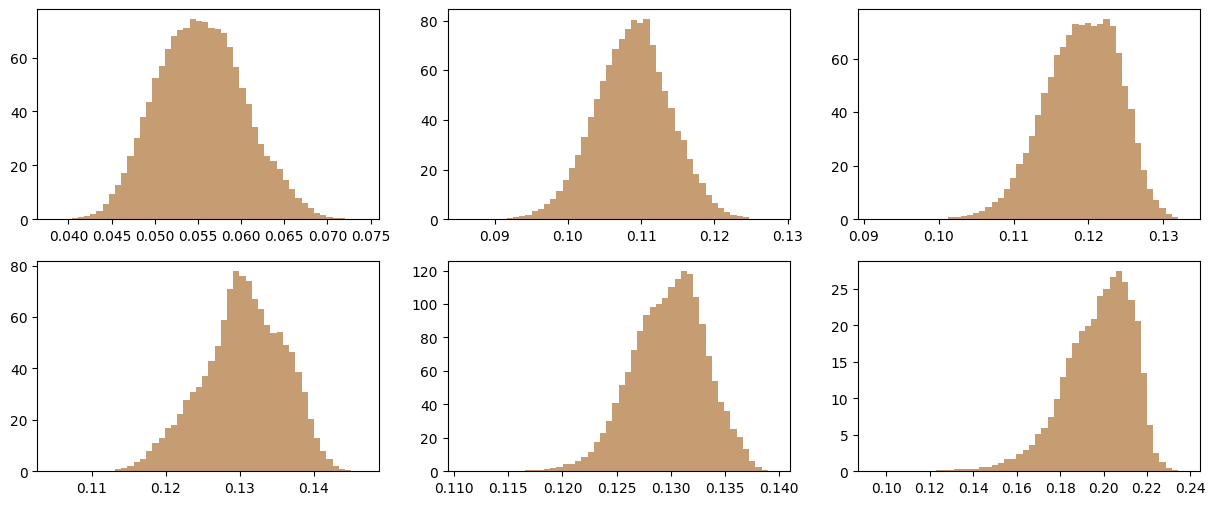

In [65]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,6)

axs[0,0].hist(cushion_list[0],density=True,bins=50,alpha=0.5)
axs[0,1].hist(cushion_list[1],density=True,bins=50,alpha=0.5)
axs[0,2].hist(cushion_list[2],density=True,bins=50,alpha=0.5)
axs[1,0].hist(cushion_list[3],density=True,bins=50,alpha=0.5)
axs[1,1].hist(cushion_list[4],density=True,bins=50,alpha=0.5)
axs[1,2].hist(cushion_list[5],density=True,bins=50,alpha=0.5)

axs[0,0].hist(init_cushion_list[0],density=True,bins=50,alpha=0.5)
axs[0,1].hist(init_cushion_list[1],density=True,bins=50,alpha=0.5)
axs[0,2].hist(init_cushion_list[2],density=True,bins=50,alpha=0.5)
axs[1,0].hist(init_cushion_list[3],density=True,bins=50,alpha=0.5)
axs[1,1].hist(init_cushion_list[4],density=True,bins=50,alpha=0.5)
axs[1,2].hist(init_cushion_list[5],density=True,bins=50,alpha=0.5)

plt.show()

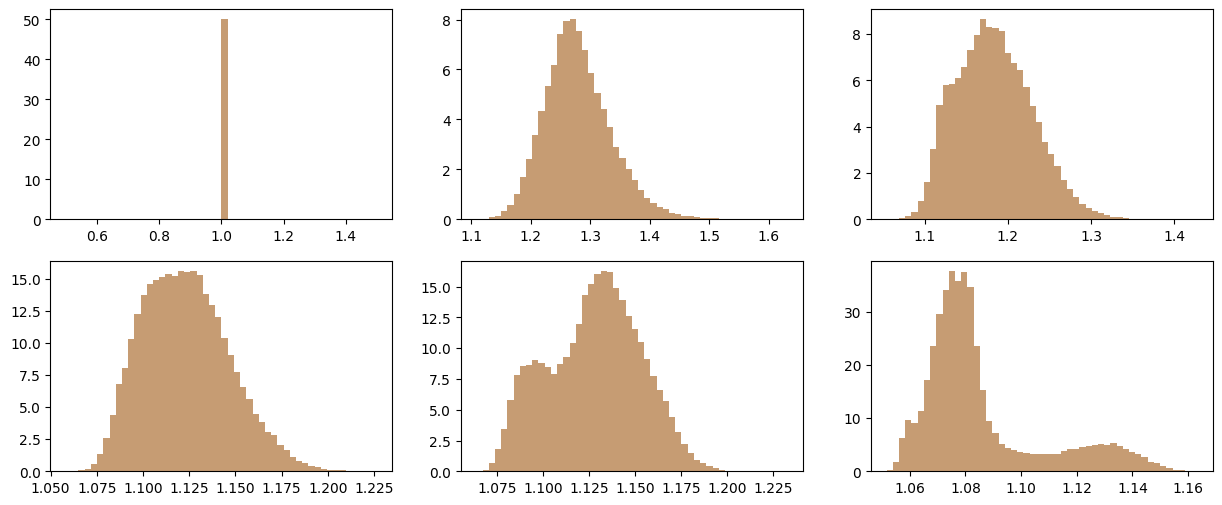

In [66]:
fig, axs = plt.subplots(2,3)
fig.set_size_inches(15,6)

axs[0,0].hist(activations[0],density=True,bins=50,alpha=0.5)
axs[0,1].hist(activations[1],density=True,bins=50,alpha=0.5)
axs[0,2].hist(activations[2],density=True,bins=50,alpha=0.5)
axs[1,0].hist(activations[3],density=True,bins=50,alpha=0.5)
axs[1,1].hist(activations[4],density=True,bins=50,alpha=0.5)
axs[1,2].hist(activations[5],density=True,bins=50,alpha=0.5)

axs[0,0].hist(init_activations[0],density=True,bins=50,alpha=0.5)
axs[0,1].hist(init_activations[1],density=True,bins=50,alpha=0.5)
axs[0,2].hist(init_activations[2],density=True,bins=50,alpha=0.5)
axs[1,0].hist(init_activations[3],density=True,bins=50,alpha=0.5)
axs[1,1].hist(init_activations[4],density=True,bins=50,alpha=0.5)
axs[1,2].hist(init_activations[5],density=True,bins=50,alpha=0.5)

plt.show()